# Adsorption, Langmuir isotherms
This notebook addresses the problem of identifying adsorption parameters based on a set of measurements of a component on both the aqueous and adsorbed phases. The cell below performs a few initialization for the following scripts. The data are loaded in log10 format and plotted for a quick look. Aqueous (resp. asdorbed) concentrations are on the $x$ (resp. $y$) axis.

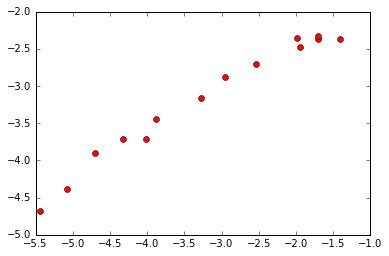

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
%matplotlib inline
data=np.loadtxt('CadmiumFerriHydrite.txt',skiprows=1)
plt.plot(data[:,0],data[:,1],'ro')

The following class describes a cadmium/ferrihydrite adsorption system. The adsorption system is composed of several adsorption sites (indicated by the class attribute **nsite**). Each site is characterized by a **kinetic constant** $K$ determining the equilibrium between aqueous and adsorbed phases, including the concentration $S$ of available site:
$$ S + A_{aqu}  <--> A_{ads}, \qquad K=\frac{A_{ads}}{S.A_{aqu}} $$
The **total site concentration** $S_{tot}$ is the sum of the concentration of available site $S$ and the concentration of adsorbing site, equal to $A_{ads}$:
$$ S_{tot} = S + A_{ads} $$
Therefore, the concentration of adsorbed component writes:
$$ A_{ads} = \frac{K.S_{tot}.A_{aqu}}{1+K.A_{aqu}} $$
Given $A_{aqu}$, the concentration $A_{ads}$ is utterly determined by the pairs of parameters $K$ and $S_{tot}$ (1 pair for each adsorption site) which are considered here as the **model parameters** and are class attributes.

The **measurement data** are also an attribute of the class. Note that they come in the _log10_ form.

In [13]:
class Adsorption:
    """Describe a cadmium/ferrihydrite adsorption system.
    """
    
    def __init__(self, Nsite=1):
        self.nsite=Nsite        # number of adsorption sites
        datain=np.loadtxt('CadmiumFerriHydrite.txt',skiprows=1)   # read from file
        self.data_aqu_log=datain[:,0]
        self.data_ads_log=datain[:,1]
        self.kin=10000*np.ones((self.nsite))   # Kinetic constants
        self.sto=0.0005*np.ones((self.nsite))   # Conc of adsorption sites
        self.b_weight = 0.01               # weight for the background term of the cost function.
        
    def compute_ads(self, aqu_in, kin_in, sto_in):
        """Compute adsorbed concentrations at each site from other aqu_in, kin_in, sto_in ."""
        dimaqu = np.shape(aqu_in)[0]
        ads_out = np.empty((dimaqu, self.nsite))
        for iv in range(dimaqu):
            for isi in range(self.nsite):
                num = sto_in[isi] * kin_in[isi] * aqu_in[iv]
                denom = 1. + kin_in[isi] * aqu_in[iv]
                ads_out[iv,isi] = num/denom
        return ads_out
                      
    def plot_ads(self, sites=None):
        """Plot -log(ads) vs -log10(aqu) based on the model parameters (class attribute).
        sites: set different from None to plot Langmuir isotherms for all adsorption sites."""
        xxaqu_log = np.arange(-5.5,-1.,0.1)
        xxaqu = 10**xxaqu_log
        xxads = self.compute_ads(xxaqu, self.kin, self.sto)
        xxads_tot = np.sum(xxads, axis=1)
        if sites != None:
            for isi in range(self.nsite):
                plt.plot(np.log10(xxaqu),np.log10(xxads[:,isi]), 'b--')
        plt.plot(np.log10(xxaqu),np.log10(xxads_tot[:]))
        plt.plot(self.data_aqu_log, self.data_ads_log, 'ro')
        
    def CostFunction(self, params):
        """Compute cost function to minimize and find kinetic constants and site concentrations. """
        cost=0.
        ## Jb
        params_ref = np.log10( np.hstack((self.kin, self.sto)) )
        incr = params - params_ref
        costb = 0.5 * self.b_weight * np.dot(incr, incr)
        ## Jo
        kin = 10**params[:self.nsite]
        sto = 10**params[self.nsite:]
        data_aqu = 10**self.data_aqu_log
        xxads = self.compute_ads(data_aqu, kin, sto)
        xxads_tot = np.sum(xxads, axis=1)
        innov = self.data_ads_log - np.log10(xxads_tot)
        costo = 0.5 * np.dot(innov, innov)
        cost = costb + costo
        return cost
        
    def optim(self):
        """Compute optimal parameters by minimizing CostFunction. Return the final cost function value. """
        params = np.log10( np.hstack((self.kin, self.sto)) )
        result = so.minimize(self.CostFunction, params, method = "Powell")
        params_out = 10**result['x']
        self.kin = params_out[:self.nsite]
        self.sto = params_out[self.nsite:]
        return result['fun']


Below, we define an adsorption system with one adsorption site and initialize the parameters with some guest values. We plot the Langmuir isotherm associated with these parameters.

([1000.0], [0.01])


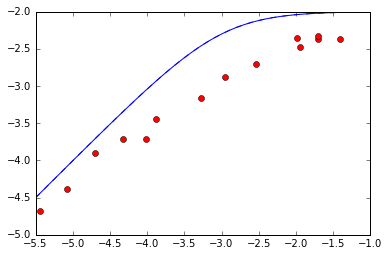

In [14]:
toto=Adsorption(Nsite=1)
toto.kin = [1000.]
toto.sto = [0.01]
print (toto.kin, toto.sto)
toto.plot_ads(sites='y')

We then run the optimization procedure to find the parameters that make the best fit to the data. We print the new parameter values and plot the new Langmuir isotherm.

[ 1003.75571738]
[ 0.00377625]


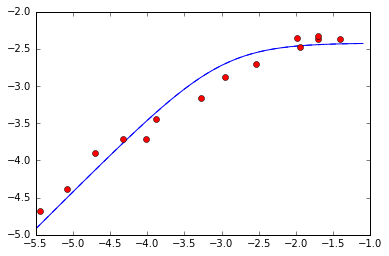

In [15]:
FinalJ = toto.optim()
print toto.kin
print toto.sto
toto.plot_ads(sites='t')

We follow the two-step procedure above with 2 adsorption sites. The dashed lines represent the isotherms for each single site (they are superposed here because they have identical parameters).

([1000.0, 1000.0], [0.01, 0.01])


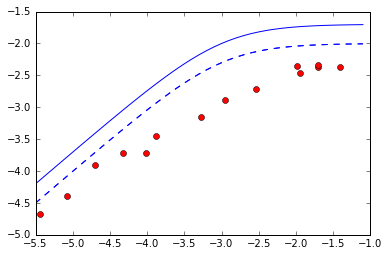

In [16]:
toto=Adsorption(Nsite=2)
toto.kin = [1000., 1000.]
toto.sto = [0.01, 0.01]
print (toto.kin, toto.sto)
toto.plot_ads(sites='t')

We optimize the parameters to fit the data and plot the results.

[ 16043.30593827    188.33311335]
[ 0.00031812  0.00503824]


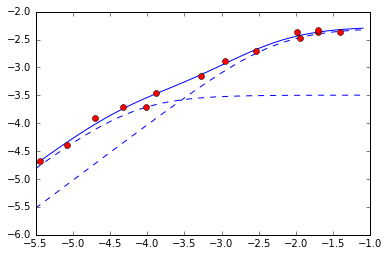

In [17]:
FinalJ = toto.optim()
print toto.kin
print toto.sto
toto.plot_ads(sites='y')

Now we know how it works, we can explore the fit for 1, 2, 3, or more adsorption sites. Will we fit the data better by including more sites? Apart for 1 site, the isotherms look similar...

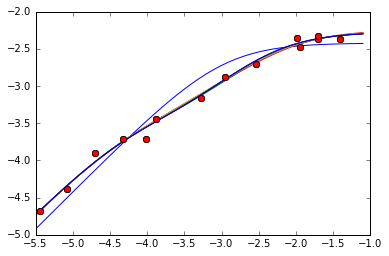

In [18]:
ns=8
Jfunc=np.empty(ns)
for isi in range(ns):
    toto=Adsorption(Nsite=isi+1)
    toto.kin = [1000.]*(isi+1)
    toto.sto = [0.01]*(isi+1)
    Jfunc[isi] = toto.optim()
    toto.plot_ads()

Let us look at the cost function for the various numbers of sites. Which number best fits the data?

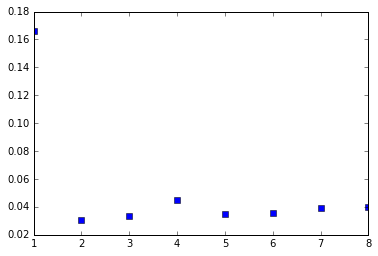

In [88]:
plt.plot(range(1,ns+1), Jfunc, 's')